In [1]:
from importlib import reload
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import subprocess
from glob import glob
from pkg import *
from pkg.functions import convert2int, convert2str, get_params
from typing import List, Dict, Any
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchvision.transforms import v2
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from skimage.filters import gaussian, sobel
from matplotlib.colors import SymLogNorm

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
# datasets = [1, 2, 3, 4, 5, 6, 7, 8, 9]
# datasets = [1, 2]
datasets = [1,4,5,6,7,8]

myPaths = path.PathManager(datasets=datasets)
myProcessor = process.Processor(paths=myPaths, datasets=datasets)
params = myProcessor.get_parameters()
print(params)
f.get_counts(paths=myPaths, datasets=datasets)

# myDatasetManager = data.DatasetManager(paths=myPaths, datasets=datasets)

# train_loader, test_loader = f.prepare(data_manager=myDatasetManager, batch_size=10)

Water backgrounds initialized: 6
{'01': {'clen': 0.15, 'photon_energy': 6000}, '04': {'clen': 0.25, 'photon_energy': 6000}, '05': {'clen': 0.25, 'photon_energy': 7000}, '06': {'clen': 0.25, 'photon_energy': 8000}, '07': {'clen': 0.35, 'photon_energy': 6000}, '08': {'clen': 0.35, 'photon_energy': 7000}}
Paths refreshed for dataset ['01', '04', '05', '06', '07', '08'].
Directory: peaks/01
	Total files: 39
	Normal images: 26
	Empty images: 13
Directory: labels/01
	Total files: 39
	Normal images: 26
	Empty images: 13
Directory: peaks_water_overlay/01
	Total files: 39
	Normal images: 26
	Empty images: 13
Directory: peaks/04
	Total files: 37
	Normal images: 25
	Empty images: 12
Directory: labels/04
	Total files: 37
	Normal images: 25
	Empty images: 12
Directory: peaks_water_overlay/04
	Total files: 37
	Normal images: 25
	Empty images: 12
Directory: peaks/05
	Total files: 36
	Normal images: 24
	Empty images: 12
Directory: labels/05
	Total files: 36
	Normal images: 24
	Empty images: 12
Directo

In [3]:
f.check_attributes(paths=myPaths, datasets=f.convert2str(datasets), dir_type='peak')
print(myProcessor.get_parameters())

# f.retrieve_attributes(file_path=myPaths.total_paths.water_background[0])

/scratch/eseveret/cxls_hitfinder/images/peaks/01/img_6keV_clen01_00020.h5 conforms to expected attributes.
/scratch/eseveret/cxls_hitfinder/images/peaks/01/img_6keV_clen01_00020.h5:
Expected Peak: True, Actual Peak: True
/scratch/eseveret/cxls_hitfinder/images/peaks/01/empty_peak_01_00008.h5 conforms to expected attributes.
/scratch/eseveret/cxls_hitfinder/images/peaks/01/empty_peak_01_00008.h5:
Expected Peak: False, Actual Peak: False
/scratch/eseveret/cxls_hitfinder/images/peaks/01/img_6keV_clen01_00024.h5 conforms to expected attributes.
/scratch/eseveret/cxls_hitfinder/images/peaks/01/img_6keV_clen01_00024.h5:
Expected Peak: True, Actual Peak: True
/scratch/eseveret/cxls_hitfinder/images/peaks/01/img_6keV_clen01_00026.h5 conforms to expected attributes.
/scratch/eseveret/cxls_hitfinder/images/peaks/01/img_6keV_clen01_00026.h5:
Expected Peak: True, Actual Peak: True
/scratch/eseveret/cxls_hitfinder/images/peaks/01/img_6keV_clen01_00017.h5 conforms to expected attributes.
/scratch/es

In [4]:
f.get_counts(paths=myPaths, datasets=datasets)
# %run process_directory.py ../../images  --percent_empty 0.5 

Paths refreshed for dataset ['01', '04', '05', '06', '07', '08'].
Directory: peaks/01
	Total files: 39
	Normal images: 26
	Empty images: 13
Directory: labels/01
	Total files: 39
	Normal images: 26
	Empty images: 13
Directory: peaks_water_overlay/01
	Total files: 39
	Normal images: 26
	Empty images: 13
Directory: peaks/04
	Total files: 37
	Normal images: 25
	Empty images: 12
Directory: labels/04
	Total files: 37
	Normal images: 25
	Empty images: 12
Directory: peaks_water_overlay/04
	Total files: 37
	Normal images: 25
	Empty images: 12
Directory: peaks/05
	Total files: 36
	Normal images: 24
	Empty images: 12
Directory: labels/05
	Total files: 36
	Normal images: 24
	Empty images: 12
Directory: peaks_water_overlay/05
	Total files: 36
	Normal images: 24
	Empty images: 12
Directory: peaks/06
	Total files: 51
	Normal images: 34
	Empty images: 17
Directory: labels/06
	Total files: 51
	Normal images: 34
	Empty images: 17
Directory: peaks_water_overlay/06
	Total files: 51
	Normal images: 34
	Emp

In [5]:
# transform = v2.Compose([
#     transform.TransformToTensor(),  # Custom transform to convert numpy array to tensor
#     v2.RandomRotation(degrees=15)         # Random rotation by +/- 15 degrees
# ])
transform = None
myDataManager = data.DatasetManager(paths=myPaths, datasets=datasets, transform=transform)
train_loader, test_loader = f.prepare(data_manager=myDataManager, batch_size=20)

Actual percentage of empty images: 33.08270676691729% across peaks, water_overlays, and labels directories.

Final dataset sizes - Peaks: 266, Labels: 266, Overlays: 266

Data prepared.
Train size: 212
Test size: 54
Batch size: 20
Number of batches in train_loader: 11 



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
scheduler = ReduceLROnPlateau

cfg = {
    "loader": [train_loader, test_loader],
    'batch_size': train_loader.batch_size,
    'device': device,
    'scheduler': scheduler
    }


peak_config = eval.Peak_Detection_Configuration(myPaths, datasets, device, save_path='../models/peak_model.pt')
print(f'weights for peak : {peak_config.get_loss_weights()}')
# photon_config = eval.Photon_Energy_Configuration(myPaths, datasets, device, save_path='../models/photon_model.pt')
# print(f'weights for photon energy : {photon_config.get_loss_weights()}')
# clen_config = eval.Camera_Length_Configureation(myPaths, datasets, device, save_path='../models/clen_model.pt')
# print(f'weights for camera length : {clen_config.get_loss_weights()}')
# locate_config = eval.Peak_Finder_Configuration(myPaths, datasets, device, save_path='../models/locate_model.pt')
# print(f'weights for peak_location : {locate_config.get_loss_weights()}')

diagram_save_path = '../../docs/diagrams/'

cuda
Paths refreshed for dataset ['01', '04', '05', '06', '07', '08'].
weights for peak : tensor([0.4944])


In [7]:
# # locate_config.get_model_diagram('first_peak_finder_model1.png', diagram_save_path, device)
# d = train_eval.TrainTestModels(cfg, locate_config)
# d.epoch_loop()
# d.plot_loss_accuracy()
# d.plot_confusion_matrix()

In [8]:
# train_loader, test_loader = f.prepare(data_manager=myDataManager, batch_size=1)

# for inputs, labels, attributes in train_loader:
    
#     break

Model testing and validating: Binary_Classification_With_Parameters
Looking for the feature: peak
-- epoch 0
Train loss: 345.7209195223722
Train accuracy: 0.3702830374240875
Test loss: 11.212776565551758
Test accuracy: 0.3333333432674408
-- learning rate : [0.0001]
-- epoch 1
Train loss: 141.20792016116056
Train accuracy: 0.4316037893295288
Test loss: 6.5941873550415036
Test accuracy: 0.2222222238779068
-- learning rate : [0.0001]
-- epoch 2
Train loss: 68.41878505186601
Train accuracy: 0.5070754885673523
Test loss: 1.8155709266662599
Test accuracy: 0.6111111044883728
-- learning rate : [0.0001]
-- epoch 3
Train loss: 42.62538259679621
Train accuracy: 0.6179245114326477
Test loss: 2.322314739227295
Test accuracy: 0.6851851940155029
-- learning rate : [0.0001]
-- epoch 4
Train loss: 40.81299918348139
Train accuracy: 0.6297169923782349
Test loss: 0.9493624567985535
Test accuracy: 0.7777777910232544
-- learning rate : [0.0001]
-- epoch 5
Train loss: 22.057729959487915
Train accuracy: 0.68

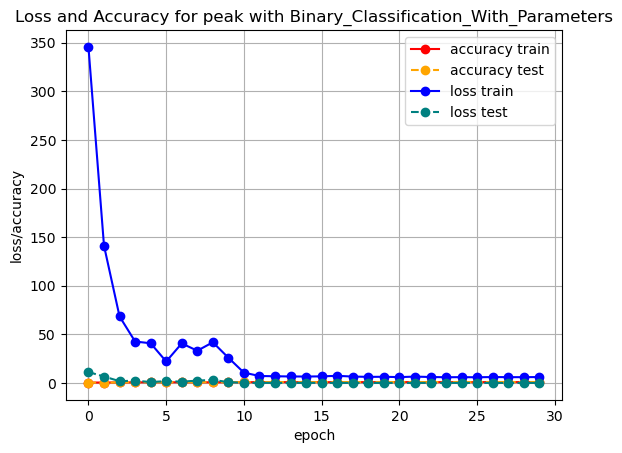

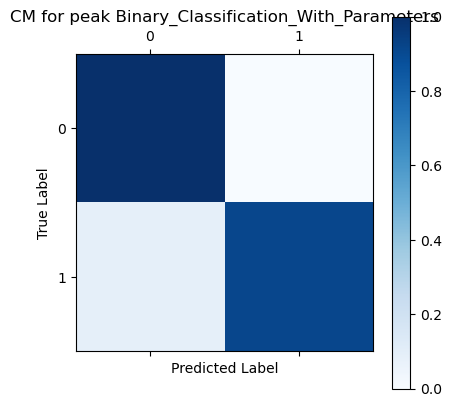

In [9]:
a = train_eval.TrainTestModels(cfg, peak_config)
a.epoch_loop()
# a.plot_loss_accuracy('../../../APM598/binary_loss5.png')
# a.find_optimal_threshold()
# a.plot_roc_curve()
# a.plot_confusion_matrix('../../../APM598/binary_confusion_matrix5.png')
a.plot_loss_accuracy()
a.plot_confusion_matrix()
# a.save_model()

In [10]:
a.get_confusion_matrix()

array([[1.        , 0.        ],
       [0.08823529, 0.91176471]])

In [11]:
# peak_config.get_model_diagram('peak_comparison_model2.png', diagram_save_path, device)

In [12]:
# b = train_eval.TrainTestModels(cfg, photon_config)
# b.epoch_loop()
# # b.plot_loss_accuracy(diagram_save_path + 'photon_energy_loss_accuracy.png')
# # b.plot_confusion_matrix(diagram_save_path + 'photon_energy_confusion_matrix.png')
# b.save_model()
# b.plot_loss_accuracy()
# b.plot_confusion_matrix()

In [13]:
# photon_config.get_model_diagram('photon_energy_model.png', diagram_save_path, device)

In [14]:
# b.get_confusion_matrix()

In [15]:
# c = train_eval.TrainTestModels(cfg, clen_config)
# c.epoch_loop()
# # c.plot_loss_accuracy(diagram_save_path + 'camera_length_loss_accuracy.png')
# # c.plot_confusion_matrix(diagram_save_path + 'camera_length_confusion_matrix.png')
# c.plot_loss_accuracy()
# c.plot_confusion_matrix()
# c.save_model()

In [16]:
# clen_config.get_model_diagram('camera_length_model.png', diagram_save_path, device)

In [17]:
# c.get_confusion_matrix()

In [18]:
# reload(pipe)
# # torch.cuda.synchronize()
# # torch.cuda.empty_cache()
# pipeline = pipe.ModelPipeline(peak_config, photon_config, clen_config, device)

In [19]:
# train_loader, test_loader = f.prepare(data_manager=myDataManager, batch_size=1)

# for inputs, labels, attributes in train_loader:
#     inputs = inputs[1]
#     # print(f'input size : {inputs.size()}')
#     print(f'-- attributes: {attributes}')
#     results = pipeline.run(inputs.to(device))
#     print(f'-- results: {results}')
#     break